# MD-SAPT: Python Based Toolkit for Running Symmetry Adapted Perturbation Theory Calculations of Molecular Dynamics Trajectories
### Alia Lescoulie, Astrid Yu, and Ashley Ringer McDonald

This Jupyter notebook demonstrates the MD-SAPT interactive user experience, showing the whole process for an example polypeptide from input to analysis.

In [1]:
# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

import mdsapt

/home/astrid/anaconda3/envs/asdf/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/home/astrid/anaconda3/envs/asdf/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


2022-03-21 15:45:13,513 mdsapt       INFO     MDSAPT v1.1.0 starting
2022-03-21 15:45:13,514 mdsapt       INFO     Copyright (c) 2021 Alia Lescoulie, Astrid Yu, and Ashley Ringer McDonald
2022-03-21 15:45:13,515 mdsapt       INFO     Released under GPLv3 License


## Step 1: Input file

MD-SAPT uses YAML a type of plain text file to pass input setting into the code. Below is a copy of the input file uses in this demo. The input file contains all the information needed to run the SAPT calculations on the trajectory including: paths to the MD data, the residues of interest, the frames to run, and the computing recourses requested. Below is the input used in this notebook. Blank inputs are generated using the `mdsapt-get-input.py` script as shown in the code block.

```bash
python mdsapt-get-input.py input.yaml
```

Afterwards the input file is filled out with the needed information.

```YAML
topology_path: 'testtop.psf'
trajectory_paths:
  - 'testtraj.dcd'
selection_resid_num:
  - 11
  - 199
int_pairs:
  # Place pair of  selections defined above in a list of lists
  - [11, 199]
trajectory_settings:
  start: 0
  stop: 98
  step: 1
system_settings:
  ncpus: '12'
  memory: '12GB'
  time: '24:00:00'
opt_settings:
  pH: 7
sapt_settings:
  method: 'sapt0'
  basis: 'jun-cc-pvdz'
  settings:
    reference: 'rhf'
  save_psi4_output: true
```

In python the input file is given to the **InputReader** which checks its validity and stores the information as variables.

In [2]:
In = mdsapt.InputReader('input.yaml')

2022-03-21 15:45:13,825 mdsapt.reader INFO     Input Parameters Accepted


**InputReader** also checks the input file for errors and give the location of issues in the input file. For example if the stop frame selected in the input file exceeds the trajectory length MD-SAPT notifies you with an error message before starting the SAPT calculation and wasting cluster time. This information is also given in `mdsapt.log` which is created when software is run.

```YAML
trajectory_settings:
  start: 78
  stop: 120
  step: 1trajectory_settings:
```

In [3]:
In2 = mdsapt.InputReader('error_input.yaml')

2022-03-21 15:45:14,055 mdsapt.reader CRITICAL Stop exceeds length of trajectory.


InputError: 

## Step 2: Preparing Residues

Residues when pulled initially from a trajectory are not able to immediatly be thrown into SAPT calcuations. They have missing protons and unpaired electrons resulting splitting the bonds forming the protein backbone. This is fixed by the **Optimizer** object in MD-SAPT. **Optimizer**, when initialized is passed **InputReader** which give it the user information.

In [4]:
Opt = mdsapt.Optimizer(In)

Residues undergo two steps in optimization, replacing amino protons, and adding a new bond on the C terminus. MD-SAPT's **Viewer** can give a continent before and after.

In [5]:
View = mdsapt.Viewer(In)

# Residue before optimization
View.view_residue(200)

NGLWidget(max_frame=97)

In [6]:
# Residue after optimization
View.view_optimized_residue(208)

NGLWidget()

Viewer also enables users to visualize the whole polypeptide as well as the interaction pairs specified in the input file.

In [7]:
View.view_system()

NGLWidget(max_frame=97)

In [8]:
View.view_optimized_interaction_pair(208, 200)

NGLWidget()

## Step 3: Run SAPT Over Trajectory Frames

After the residues are prepared, SAPT is run on the specificed residues using the **TrajectorySAPT** object. It performs several steps:
1. Getting the trajectory cooridnates from the MD files
2. Repairing the selected residues with **Optimizer**
3. Converting the residue coordinates into a Psi4 input file
4. Running the SAPT calculation with the Psi4 method and basis set specified in `input.yaml`
5. Saving the results into a **DataFrame** for easy analysis

Due to the limited memory in a Binder instance, the SAPT calculations for this trajectory were pre-run on a more powerful server, and the **TrajectorySAPT** object was "pickled" so it can be demonstrated here.

In [9]:
import pickle

try:
    # SAPT takes a very long time! On a 32-core machine with 74GiB allocated,
    # it took about 2 hours. So, we pre-ran a TrajectorySAPT for this demo 
    # notebook.
    with open('sapt_run.pkl', 'rb') as file:
        sapt_run = pickle.load(file)

except FileNotFoundError:
    # If you really want to run the entire SAPT yourself, delete sapt_run.pkl
    # and run this cell again.
    sapt_run = mdsapt.TrajectorySAPT(In, Opt)
    sapt_run.run(start=In.start, stop=In.stop, step=In.step)
    with open('sapt_run.pkl', 'wb') as file:
        pickle.dump(sapt_run, file)

## Step 4: Results Analysis

With the results **DataFrame**, the interaction energies can be viewed and used to generate figures.

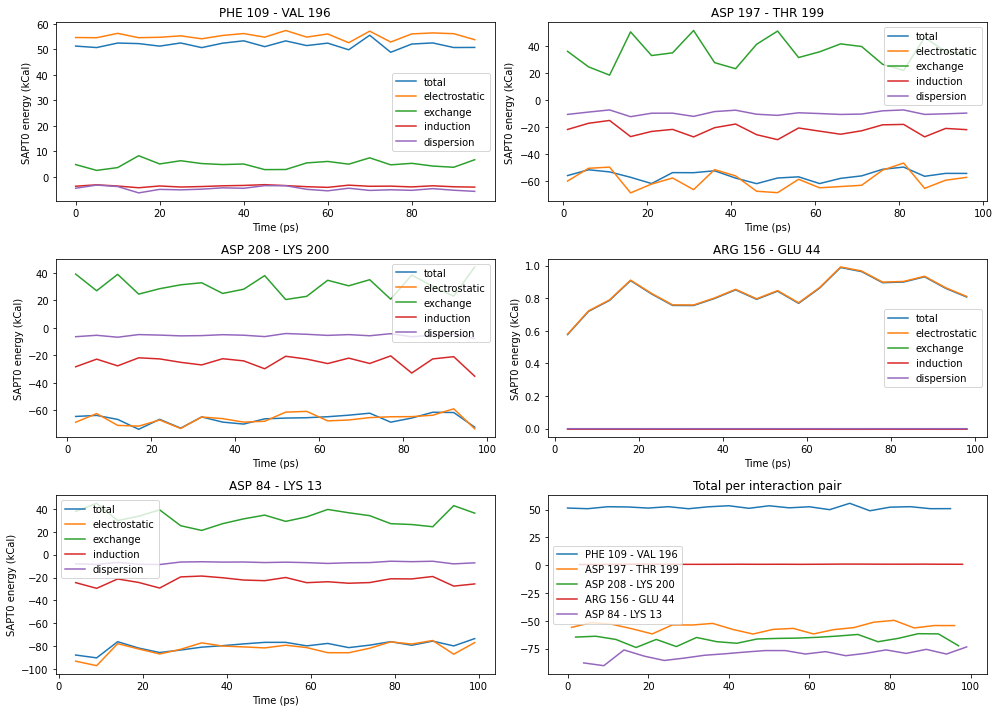

In [10]:
import matplotlib.pyplot as plt

# Alias for convenience
results = sapt_run.results

# Generate 3x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

# Draw individual pairs in first 5, and total in last 1.
indiv_axs = axs[:5]
total_ax = axs[-1]

residue_pairs = results['residues'].unique()

total_ax.set_title('Total per interaction pair')

for r_pair, ax in zip(residue_pairs, indiv_axs):
    # Filter the results by those associated with this pair.
    df = results.loc[results['residues'] == r_pair]
    
    # From the residue pair numbers, grab their amino acid names.
    a, b = map(int, r_pair.split('-'))
    ra, rb = (Opt._resids[a].universe._topology.resnames.values[int(k) - 1] for k in (a, b))
    i_name = f'{ra} {a} - {rb} {b}'

    # Plot individual interactions on their own subplots.
    ax.set_title(i_name)
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('SAPT0 energy (kCal)')
    for key in ['total', 'electrostatic', 'exchange', 'induction', 'dispersion']:
        ax.plot(df[key], label=key)
    
    # Plot total interactions on the aggregated axis.
    total_ax.plot(df['total'], label=i_name)

# Draw legends per-axis.
for ax in axs:
    ax.legend()

fig.tight_layout()
plt.show()